In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import strid
import scipy.linalg as sp
import scipy.signal
from beef.newmark import newmark_lin

### To move to utils: 

In [2]:
def norm2(v):
    """Return the Euler norm of v.
    Return the Euler norm :math:`||v||_2`.
    Arguments
    ---------
    v : 1darray
        Vector to find the norm of.
    Returns
    -------
    float : Euler norm of v.
    """
    return np.linalg.norm(v, 2)

In [3]:
class ShearFrame_mod(object):
    def __init__(self, n, m, EI,h):
        """Create a shear frame object
        Define the shear frame with the mass `m` of each floor,
        stiffness `k` of each column, and the number of storeys
        `n`, see figure below.
                    m          DOF
                ========= --->  n
                |       |
              k |       | k
                |   m   |
                ========= --->  n-1
                |       |
              k |       | k
                |   m   |
                ========= --->  n-2
                |       |
                :       :
                :       :
                |   m   |
                ========= --->  3
                |       |
              k |       | k
                |   m   |
                ========= --->  2
                |       |
              k |       | k
                |   m   |
                ========= --->  1
                |       |
              k |       | k
                |       |
               +++     +++
        The natural frequencies and the modeshapes of this system
        can be determined analytically. The `r`th natural frequency
        of a shear frame is defined by
            w_r = 2 * sqrt(k / m) * sin(p * (2r-1) / 2) / (2n+1)
        and the `i`th element of the `r`th mode shape is defined by
            phi =  sin(i *pi*(2r-1)/(2n+1))
        Arguments
        ---------
        n : int
            Number of storeys and also the number of DOF of the dynamic
            system.
        m : float
            Mass of each floor
        k : float
            Stiffness of each column in each storey.
        """
        self.n = n
        self.m = m
        self.h=h
        self.EI=EI

        self.k = 12*EI/h**3
        self.M = np.eye(n) * m
        self.K = self._get_K()
        self.C = np.zeros_like(self.M)

    def _get_K(self):
        k, n = self.k, self.n
        K = np.zeros((n, n), float)
        for i in range(n):
            K[i, i] = 2 * k
            if i > 0:
                K[i-1, i] = -k
            if i < n-1:
                K[i+1, i] = -k
        K[-1, -1] = k
        return K
    

    def get_natural_frequency(self, r):
        """Returns the analytical natural frequency of mode `r`
        Arguments
        ---------
        r : int
            Mode to return the frequency for.
        Returns
        -------
        float
            Natural frequency of mode `r` in rad/s
        """
        k, m, n = self.k, self.m, self.n
        return 2 * np.sqrt(k / m) * np.sin(np.pi / 2 * (2*r-1) / (2*n+1))

    def get_mode_shape(self, r):
        """Returns the analytical mode shape of mode `r`
        Arguments
        ---------
        r : int
            Mode to return the mode shape for.
        Returns
        -------
        1darray
            Mode shape of mode `r`, the mode shape is normalized
            to have unit length.
        """
        x = np.array([np.sin(i*np.pi*(2*r-1)/(2*self.n+1))
                      for i in range(1, self.n+1)])
        return x / norm2(x)

    def set_rayleigh_damping_matrix(self, freqs, xis):
        """Set the damping matrix to the Rayleigh damping matrix
        Rayleigh damping is a classical damping matrix which defines
        the modal damping ratio x(w) by the following equation
            xi(w) = 1/2 * (a/w + b*w)
        where w is the frequency in rad/s and a and b are the Rayleigh
        damping coefficients. Specify the damping ratio for atleast two
        frequencies, if more than two damping ratios are specified, the
        Rayleigh damping coefficients are determined by least squre fitting.
        Arguments
        ---------
        freqs : 1darray
            Frequencies (rad/s) where the damping ratios are specified
        damping_ratios : 1darray
            The damping ratios (c / c_cr) at the specified frequencies.
        """
        a, b = find_rayleigh_damping_coeffs(freqs, xis)
        self._rayleigh_coeffs = (a, b)
        self.C = a*self.M + b*self.K

    def get_rayleigh_damping_ratio(self, r):
        """Returns the Rayleigh damping ratio of mode `r`
        It is assumed that Rayleigh damping is set, see
        set_rayleigh_damping_matrix method.
        Arguments
        ---------
        r : int
            Mode to return the damping ratio for.
        Returns
        -------
        float
            Damping ratio of mode `r`
        """

        a, b = self._rayleigh_coeffs
        w = self.get_natural_frequency(r)
        return .5*(a/w+b*w)

    @property
    def state_matrix(self):
        "CT State space  matrix (B)"
        M, C, K = self.M, self.C, self.K
        Z = np.zeros_like(M)
        I = np.eye(M.shape[0])
        A11 = -np.linalg.solve(M, C)
        A12 = -np.linalg.solve(M, K)
        A = np.r_[np.c_[A11, A12],
                  np.c_[I, Z]]
        return A

    @property
    def input_influence_matrix(self):
        "CT State space input influence matrix (B)"
        return np.r_[np.linalg.solve(self.M, np.eye(self.n)),
                     np.zeros((self.n, self.n))]

    def get_state_space_matrices(self):
        "Continous time state space matrices A, B, C, D"
        A = self.state_matrix
        B = self.input_influence_matrix
        n = self.n
        O = np.zeros((n, n))
        I = np.eye(n)
        C = np.r_[A[:n, :],
                  np.c_[I, O],
                  np.c_[O, I]]
        D = np.r_[np.linalg.solve(self.M, I),
                  O,
                  O]
        return A, B, C, D

    def simulate(self, t, F=None, d0=None, v0=None):
        """Obtain system response to load and initial conditions.
        Simulate the system response at time points `t` due to loads
        `F` and with initial displacements `d0` and velocities `v0`.
        Arguments
        ---------
        t : 1darray
            Time points to evaluate the system response.
        F : 2darray, optional
            Load matrix where each column corresponds to time points in
            `t` and each row is the load applied to a system dof. Fij is
            then the load applied to dof `i` at time `j`. Zeros is assumed
            if None.
        d0, v0 : 1darray, optional
            Initial displacment and velocity vector. Zeros is assumed
            if None.
        Returns
        -------
        A, V, D : 2darray
            Acceleration, velocity and displacement vector for the system.
        """
        n = self.n
        d0 = np.zeros(n) if d0 is None else d0
        v0 = np.zeros(n) if v0 is None else v0
        x0 = np.r_[v0, d0]

        sys = scipy.signal.StateSpace(*self.get_state_space_matrices())
        U = np.zeros((t.size, n)) if F is None else F.T

        _, y, _ = scipy.signal.lsim(sys, U, t, X0=x0)
        y = y.T
        A = y[:n, :]
        V = y[n:2*n, :]
        D = y[2*n:, :]
        return A, V, D


def find_rayleigh_damping_coeffs(w, damping_ratios):
    """Rayleigh damping coefficients from target freqs and damping ratio
    Rayleigh damping is defined by the following relation
    .. math::
        C = aM + bK
    where :math:`C` is the damping matrix, :math:`M` is the mass
    matrix and :math:`K` is the stiffness matrix. The damping ratio
    :math:`\\xi` at angular frequency :math:`\\omega` is then given by
    the following equation:
    .. math::
       \\xi = \\frac{1}{2}(\\frac{a}{\\omega} + b\\omega)
    The damping coefficients is determined by specifying the desired
    damping ratio at two or more frequencies by the least square
    method.
    Arguments
    ---------
    w : 1darray
        Angular frequencies (rad/s) where the damping ratios are
        specified
    damping_ratios : 1darray
        The damping ratios (c / c_cr) at the specified frequencies.
    Returns
    -------
    a, b : float
        Rayleigh dampping coefficients
    """
    A = .5 * np.array([[1 / wn, wn]
                       for wn in w])
    return np.linalg.lstsq(A, damping_ratios, rcond=None)[0]

In [109]:
class ShearFrame_3D():
    def __init__(self):
        '''Class for constructing a 3D shear frame whith indevidual stiffness for 
        each floor, in both directions. Each floor have two DOFs located 
        perpendicular to each other in the slab center. '''


        pass

    def set_mass_and_stiffness(self,kx,ky,m):
        '''Arguments: 
        kx: 1darray
            total stiffness for each floor i x-direction. 
            First entry is the lower column 
        ky: 1darray
            total stiffness of each floor in y-direction. 
            Same length as kx
        m: 1darray
            The masses of the floors. one entry for each floor. 
            First entry is the mass of the first floor. '''

        self.kx=kx
        self.ky=ky
        self.m=m
    
        KKx=np.zeros((len(self.kx),len(self.kx)))
        KKy=np.zeros((len(self.ky),len(self.ky)))

        for i in range(len(self.kx)):
            if i==0:    # bottom floor
                KKx[i,i]+=self.kx[i]+self.kx[i+1]
                KKx[i,i+1]-=self.kx[i+1]
                KKx[i+1,i]-=self.kx[i+1]
                KKy[i,i]+=self.ky[i]+self.ky[i+1]
                KKy[i,i+1]-=self.ky[i+1]
                KKy[i+1,i]-=self.ky[i+1]

            elif i==len(self.kx)-1:  # top floor
                KKx[i,i]+=self.kx[i]
                KKy[i,i]+=self.ky[i]

            else:       #other floors
                KKx[i,i]+=self.kx[i]+self.kx[i+1]
                KKx[i,i+1]-=self.kx[i+1]
                KKx[i+1,i]-=self.kx[i+1]
                KKy[i,i]+=self.ky[i]+self.ky[i+1]
                KKy[i,i+1]-=self.ky[i+1]
                KKy[i+1,i]-=self.ky[i+1]
        self.KKx=KKx
        self.KKy=KKy
        self.KK=np.block([[KKx, np.zeros_like(KKx)],
                          [np.zeros_like(KKy), KKy]])

        MM=np.zeros((len(self.m),len(self.m)))
        for i in range(len(self.m)): 
            MM[i,i]=self.m[i]
        self.MMxy=MM
        self.MM=np.block([[MM, np.zeros_like(MM)],
                          [np.zeros_like(MM), MM]])
        
        #solves eigenvalue problems
        lambd_x,phi_x =sp.eig(self.KKx,self.MMxy)   
        lambd_y,phi_y =sp.eig(self.KKy,self.MMxy)   
        self.true_wx=np.sqrt(np.real(lambd_x[np.argsort(lambd_x)]))
        self.true_wy=np.sqrt(np.real(lambd_y[np.argsort(lambd_y)]))

        self.eigenvecs_x=np.array([phi_x[:,i]for i in np.argsort(lambd_x)])/np.max(phi_x)
        self.eigenvecs_y=np.array([phi_y[:,j]for j in np.argsort(lambd_y)])/np.max(phi_y)

    def set_damping(self,*args,cx=None,freqs_x=None,cy=None,freqs_y=None,Cx=None,Cy=None): 
        '''Function for creating a damping matrix for the system. By default Rayleigh
        damping with 5% damping specified in first and second mode in
        each direction is assumed.

        If more than two damping ratios are specified, the
        Rayleigh damping coefficients are determined by least squre fitting

        Run after set_mass_and_stiffness
        
        Arguments:
            cx:  1darray, optional
                Array of the desired damping ratios c/c_cr in x-direction
            freqs_x: 1darray, optional
                Array of the frequencies where the damping ratios are spicified
            cy:  1darray, optional
                Array of the desired damping ratios c/c_cr i y-direction
            freqs_y: 1darray, optional
                Array of the frequencies where the damping ratios are spicified
            Cx: ndarray, optional
                Complete damping matrix for the system in x direction, if desired. If not
                specified Rayleigh damping is assumed.
            Cy: ndarray, optional
                Complete damping matrix for the system in y direction, if desired. If not
                specified Rayleigh damping is assumed.'''

        if Cx: 
            self.CCx=Cx
        else: 
            # defining the rayleigh damping matrix:
            if not cx: 
                cx=np.array([0.05,0.05])
                freqs_x=self.true_wx[0:2]
            A=0.5* np.array([[1/wn,wn]for wn in freqs_x])
            print(A)
            ax,bx = np.linalg.lstsq(A, cx, rcond=None)[0]
            self.CCx=ax*self.MMxy+bx*self.KKx
            self.damping_ratios_x=0.5*(ax/self.true_wx+bx*self.true_wx)
        if Cy: 
            self.CCy=Cy
        else: 
            # defining the rayleigh damping matrix:
            if not cy: 
                cy=np.array([0.05,0.05])
                freqs_y=self.true_wy[0:2]
            A= 0.5* np.array([[1/wn,wn]for wn in freqs_y])
            ay,by = np.linalg.lstsq(A, cy, rcond=None)[0]
            self.CCy=ay*self.MMxy+by*self.KKy
            self.damping_ratios_y=0.5*(ay/self.true_wy+by*self.true_wy)
                
        self.CC=np.block([[self.CCx, np.zeros_like(self.CCx)],
                          [np.zeros_like(self.CCy), self.CCy]]) 
        

        
    def simulate_response(self,t,F,*args,u0=None,du0=None):
        '''Function for obtaining a response for a given load- and time series
        
        Arguments: 
            F: 2darray
                Array containing the load for each dof. 
            t: 1darray
                Linear array contaning the time steps corresponding to the loads

                Shapes:
                t :  [ t1,  t2,  ...   , tn ]
            
                F :[ 
                    [ p1(t1), ... ,  p1(tn)]  <-- dof1, first floor x-dir:
                    .
                    [ pm(t1), ... ,  pm(tn)]  <-- dofm, top floor x-dir
                    [ pm+1(t1), ... ,pm+1(tn)]<-- dofm+1, first floor y-dir
                    .
                    [ pn(t1), ... ,  pn(tn)]  <-- dofn top floor y-dir    
                    ]  
                    '''

        Fx=F[:len(F)//2] # first half of 
        if u0:
            u0x=u0[:len(u0)//2]
        else:
            u0x=np.zeros(len(F)//2)

        if du0:
            du0x=du0[:len(du0)//2]
        else:
            du0x=np.zeros(len(F)//2)
        ux, dux, ddux = newmark_lin(self.KKx, self.CCx, self.MM, Fx, t, u0x, du0x)
        return ux,dux,ddux


    @property
    def state_matrix(self):
        "CT State space  matrix (B)"
        M, C, K = self.MM, self.CC, self.KK
        Z = np.zeros_like(M)
        I = np.eye(M.shape[0])
        A11 = -np.linalg.solve(M, C)
        A12 = -np.linalg.solve(M, K)
        A = np.r_[np.c_[A11, A12],
                  np.c_[I, Z]]
        return A

    @property
    def input_influence_matrix(self):
        "CT State space input influence matrix (B)"
        n=len(self.KK)
        return np.r_[np.linalg.solve(self.MM, np.eye(n)),
                     np.zeros((n, n))]

    def get_state_space_matrices(self):
        "Continous time state space matrices A, B, C, D"
        A = self.state_matrix
        B = self.input_influence_matrix
        n = len(self.KK)
        O = np.zeros((n, n))
        I = np.eye(n)
        C = np.r_[A[:n, :],
                  np.c_[I, O],
                  np.c_[O, I]]
        D = np.r_[np.linalg.solve(self.MM, I),
                  O,
                  O]
        return A, B, C, D


    def simulate_response(self,t,F,*args,u0=None,du0=None):
        '''Function for obtaining a response for a given load- and time series. State space solution from Strid.
        
        Arguments: 
            F: 2darray
                Array containing the load for each dof. 
            t: 1darray
                Linear array contaning the time steps corresponding to the loads

                Shapes:
                t :  [ t1,  t2,  ...   , tn ]
            
                F :[ 
                    [ p1(t1), ... ,  p1(tn)]  <-- dof1, first floor x-dir:
                    .
                    [ pm(t1), ... ,  pm(tn)]  <-- dofm, top floor x-dir
                    [ pm+1(t1), ... ,pm+1(tn)]<-- dofm+1, first floor y-dir
                    .
                    [ pn(t1), ... ,  pn(tn)]  <-- dofn top floor y-dir    
                    ]  
                    

        Returns:
            ddu,du,u: 2darrays
                    All with same shape as F

        '''
        n = len(self.KK)
        u0 = np.zeros(n) if u0 is None else u0
        du0 = np.zeros(n) if du0 is None else du0
        x0 = np.r_[du0, u0]

        sys = scipy.signal.StateSpace(*self.get_state_space_matrices())
        U = np.zeros((t.size, n)) if F is None else F.T

        _, y, _ = scipy.signal.lsim(sys, U, t, X0=x0)
        y = y.T
        A = y[:n, :]
        V = y[n:2*n, :]
        D = y[2*n:, :]
        return A, V, D

    # def shear_beam(x1,x2,y1,y2):
    #     '''Generate shape of shear beam for plotting'''
    #     x_temp=np.linspace(-10,10,100)
    #     y=x_temp**3/(100**3)
    def display_system(self,F,U,t): 
        '''Display the shear frame, the loading and the response.
        Arguments: 
            F: 2darray
                loading, same input as '.simulate_response'
            U: 2darray
                the desired response, displacement, velocity or acceleration. 
        
        '''
        n_story=len(self.KK)//2
        figure=plt.figure(figsize=(15,n_story*3*2+2*3))

        ax=plt.subplot2grid((n_story*4+5,3),(0,0),1,1,fig=figure)
        ax.set_axis_off()
        ax.text(0.25,0.25,'Loading',fontsize=40)

        ax=plt.subplot2grid((n_story*4+5,3),(0,1),1,1,fig=figure)
        ax.set_axis_off()
        ax.text(0.25,0.25,'X-direction',fontsize=40,)     
        
        ax=plt.subplot2grid((n_story*4+5,3),(0,2),1,1,fig=figure)
        ax.set_axis_off()
        ax.text(0.25,0.25,'Response',fontsize=40)       

        # last - plots:
        Fmax=np.amax(F)
        Fmin=np.amin(F)
        for i,ui in enumerate(F[:n_story]):
            ax=plt.subplot2grid((n_story*4+5,3),(2*(n_story-i)-1,0),2,1,fig=figure)
            ax.plot(t,ui)
            ax.set_xlim(t[0],t[-1])
            ax.set_ylim(Fmin,Fmax)
            ax.spines['bottom'].set_position(('data',0))
            ax.spines['top'].set_position(('data',0))
            ax.spines['right'].set_position(('data',0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        
        #Response
        Umax=np.amax(U)
        Umin=np.amin(U)
        for i,ui in enumerate(U[:n_story]):
            ax=plt.subplot2grid((n_story*4+5,3),(2*(n_story-i)-1,2),2,1,fig=figure)
            ax.plot(t,ui)
            ax.set_xlim(t[0],t[-1])
            ax.set_ylim(Umin,Umax)
            ax.spines['bottom'].set_position(('data',0))
            ax.spines['top'].set_position(('data',0))
            ax.spines['right'].set_position(('data',0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

        # Frame:
        for i in range(n_story):
            ax=plt.subplot2grid((n_story*4+5,3),(2*(n_story-i),1),2,1,fig=figure)
            ax.set_xlim(-0.5,1.5)
            ax.set_ylim(0,1)
            ax.set_axis_off()
            x=([0,0])
            y1=([0,1])
            y2=([1,1])
            if i==0:
                ax.plot(([-0.1,0.1]),x,linewidth=10,color='black')
                ax.plot(([0.9,1.1]),x,linewidth=10,color='black')
                ax.plot(([-0.5,1.5]),x,linewidth=5,color='black')
            ax.plot(x,y1,linewidth=10,color='black')
            ax.plot(y1,y2,linewidth=40,color='black')
            ax.plot(y2,y1,linewidth=10,color='black')
            ax.text(0.2,0.8,'M = '+str(round(self.m[i],2)),fontsize=25)  
            ax.text(0.08,0.4,'K = '+str(round(self.kx[i],2)),fontsize=25)  
            plt.scatter([-0.3,1.3],[0.96,0.96],marker=9,s=150,c='black')
            plt.scatter([-0.3,1.3],[0.96,0.96],marker=0,s=200,c='black')

        #Seperating lines: 
        ax=plt.subplot2grid((n_story*4+5,3),(2*(n_story)+1,0),1,1,)
        ax.plot(([-0.5,1.5]),x,linewidth=5,color='black')
        ax.set_xlim((-0.5,1.5))
        ax.set_ylim((0,1))
        ax.set_axis_off()

        ax=plt.subplot2grid((n_story*4+5,3),(2*(n_story)+1,2),1,1,)
        ax.plot(([-0.5,1.5]),x,linewidth=5,color='black')
        ax.set_xlim((-0.5,1.5))
        ax.set_ylim((0,1))
        ax.set_axis_off()

        ##### Y-direction:
        # 
        a=2*n_story+2 
        ax=plt.subplot2grid((n_story*4+5,3),(a,0),1,1,fig=figure)
        
        ax.set_axis_off()
        ax.text(0.25,0.25,'Loading',fontsize=40)

        ax=plt.subplot2grid((n_story*4+5,3),(a,1),1,1,fig=figure)
        ax.set_axis_off()
        ax.text(0.25,0.25,'Y-direction',fontsize=40,)     
        
        ax=plt.subplot2grid((n_story*4+5,3),(a,2),1,1,fig=figure)
        ax.set_axis_off()
        ax.text(0.25,0.25,'Response',fontsize=40)       

        # last - plots:
        

        Fmax=np.amax(F)
        Fmin=np.amin(F)
        # a+=1
        for i,ui in enumerate(F[n_story:]):
            ax=plt.subplot2grid((n_story*4+5,3),(a+2*(n_story-i)-1,0),2,1,fig=figure)
            ax.plot(t,ui)
            ax.set_xlim(t[0],t[-1])
            ax.set_ylim(Fmin,Fmax)
            ax.spines['bottom'].set_position(('data',0))
            ax.spines['top'].set_position(('data',0))
            ax.spines['right'].set_position(('data',0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        
        #Response
        Umax=np.amax(U)
        Umin=np.amin(U)
        for i,ui in enumerate(U[n_story:]):
            ax=plt.subplot2grid((n_story*4+5,3),(a+2*(n_story-i)-1,2),2,1,fig=figure)
            ax.plot(t,ui)
            ax.set_xlim(t[0],t[-1])
            ax.set_ylim(Umin,Umax)
            ax.spines['bottom'].set_position(('data',0))
            ax.spines['top'].set_position(('data',0))
            ax.spines['right'].set_position(('data',0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

        # Frame:
        for i in range(n_story):
            ax=plt.subplot2grid((n_story*4+5,3),(a+2*(n_story-i),1),2,1,fig=figure)
            ax.set_xlim(-0.5,1.5)
            ax.set_ylim(0,1)
            ax.set_axis_off()
            x=([0,0])
            y1=([0,1])
            y2=([1,1])
            if i==0:
                ax.plot(([-0.1,0.1]),x,linewidth=10,color='black')
                ax.plot(([0.9,1.1]),x,linewidth=10,color='black')
            ax.plot(x,y1,linewidth=10,color='black')
            ax.plot(y1,y2,linewidth=40,color='black')
            ax.plot(y2,y1,linewidth=10,color='black')
            ax.text(0.2,0.8,'M = '+str(round(self.m[i],2)),fontsize=25)  
            ax.text(0.08,0.4,'K = '+str(round(self.ky[i],2)),fontsize=25)  
            plt.scatter([-0.3,1.3],[0.96,0.96],marker=9,s=150,c='black')
            plt.scatter([-0.3,1.3],[0.96,0.96],marker=0,s=200,c='black')


        plt.tight_layout(h_pad=-1)
        return figure
        


In [5]:
class load_series(): 
    def __init__(self,t): 
        '''Function for obtaining a response for a given load- and time series
        
        Arguments: 
            t: 1darray
                Linear array contaning the time steps corresponding to the loads
                t :  [ t1,  t2,  ...   , tn ]'''
        self.F=np.zeros_like(t)
    
    def add_white_noise(self,amplitude):
        '''Add white noise to the load
        Arguments: 
            Amplitude: float
                Highest amplitude of the noise'''
        self.F +=np.random.normal(size=(np.shape(self.F)))* amplitude


    
        


### Testing

In [6]:
ramme_3=ShearFrame_mod(4,1000,10000,3)
ramme_4=ShearFrame_mod(5,1000,10000,3.2)

print(ramme_3.get_mode_shape(3))
print(ramme_3.get_natural_frequency(3))

print(ramme_4.get_mode_shape(3))
print(ramme_4.get_natural_frequency(3))



[ 0.6565385  -0.22801343 -0.57735027  0.42852507]
3.2299269722283617
[ 0.59688479  0.16989112 -0.54852873 -0.32601868  0.45573414]
2.5063666417975616


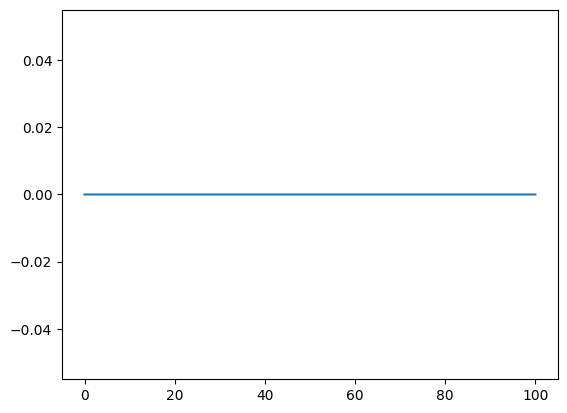

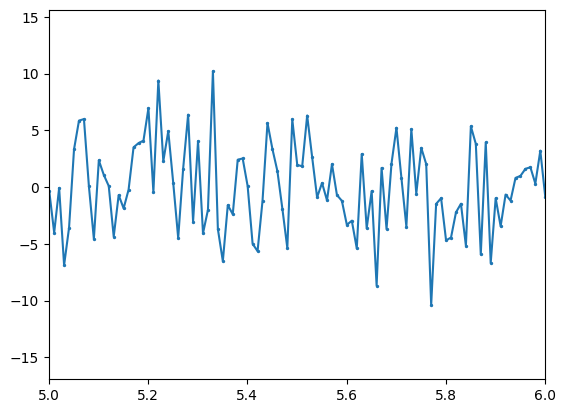

In [7]:
t=np.linspace(0,100,10000)
load=load_series(t)
F=load.F

plt.plot(t,F)
plt.show()

load.add_white_noise(4)

plt.plot(t,F)
plt.scatter(t,load.F,s=2)
plt.xlim(5,6)
plt.show()

[[0.45305496 0.55180944]
 [0.14439016 1.73141988]]


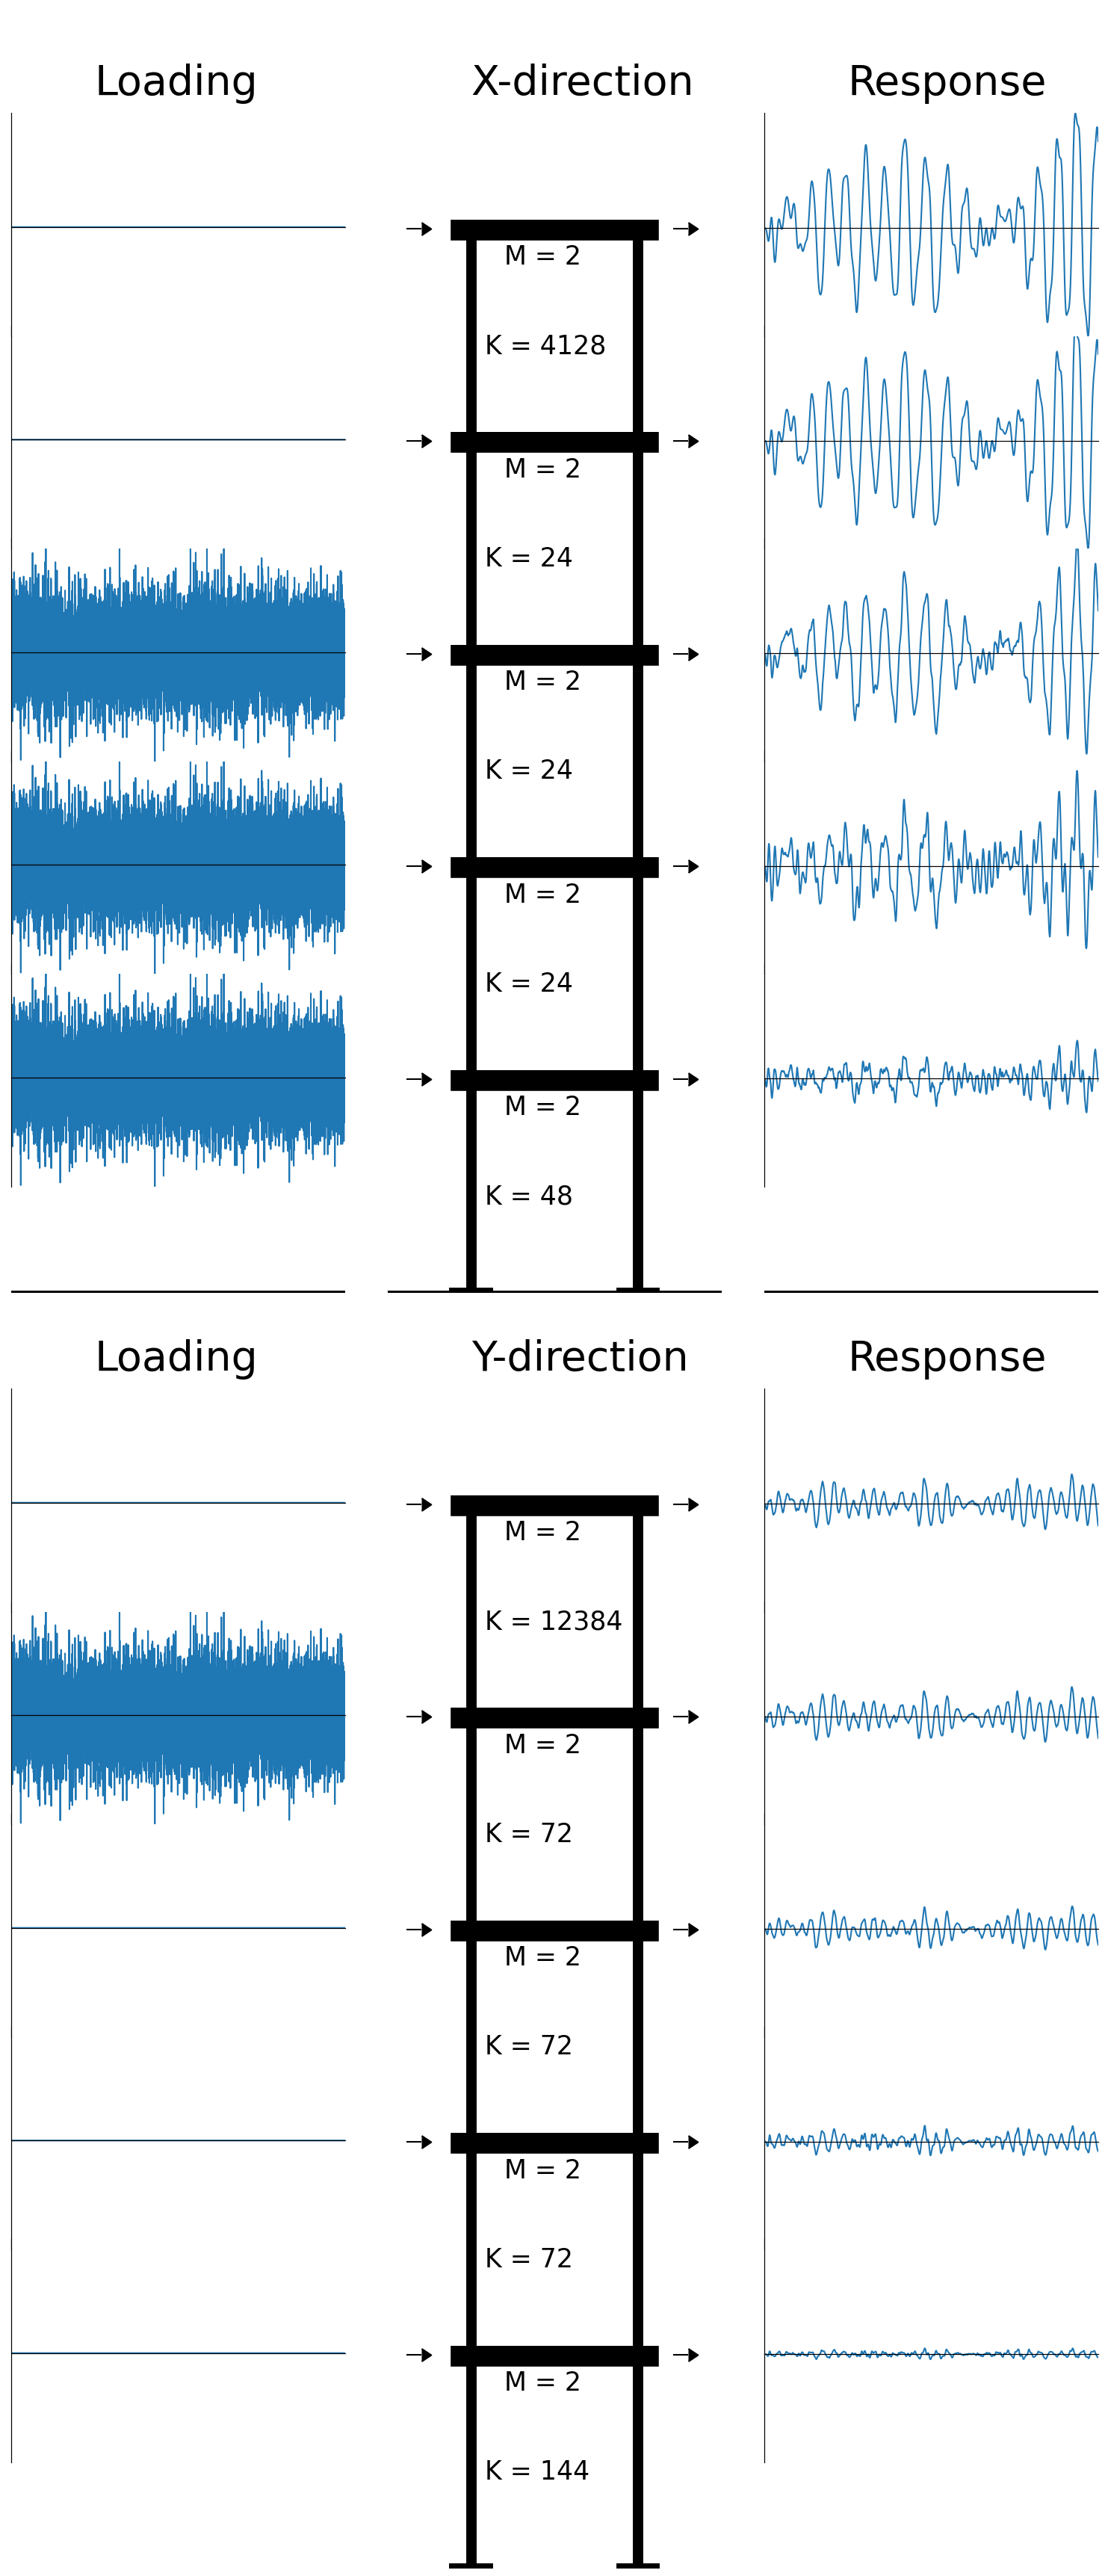

In [112]:
import time
load=load_series(t)
load.add_white_noise(1)
loading=np.array([load.F]*10)
loading[3:]*=0
# loading[0]=3
loading[8]=loading[1]



kx=np.array([4,2,2,2,344])*12
ky=kx*3
m=np.array([2,2,2,2,2])

ramme=ShearFrame_3D()
ramme.set_mass_and_stiffness(kx,ky,m)

ramme.set_damping()

t0=time.time()

ddu,du,u=ramme.simulate_response(t,loading)

# ramme_strid=ShearFrame_mod(3,2,2,1)


# wn1=ramme_strid.get_natural_frequency(1)
# wn2=ramme_strid.get_natural_frequency(2)
# freqs=np.array([wn1,wn2])
# xis=np.array([0.05,0.05])
# ramme_strid.set_rayleigh_damping_matrix(freqs,xis)
# t2=time.time()
# ddu_strid,du_strid,u_strid=ramme_strid.simulate(t,loading[0:3])
# t3=time.time()-t2
# print('time strid: ',t3)
# print(ramme_strid.get_rayleigh_damping_ratio(3))


plt.show(ramme.display_system(loading,u,t))
plt.close()

NameError: name 'u_strid' is not defined

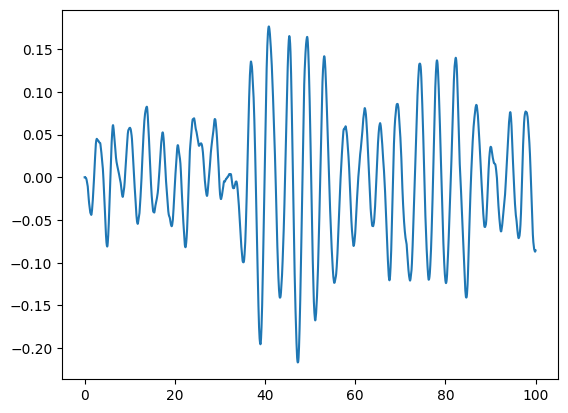

In [9]:
plt.plot(t,u[2])
plt.plot(t,u_strid[2]*0.9)




In [ ]:
x1=1
x2=2
y1=0
y2=0.1


x_temp=np.linspace(-1,1,100)
y_shape=(x_temp**27+2*x_temp**3+2*x_temp)*(y2-y1)
plt.plot(x_temp,y_shape)
plt.xlim(-4,4)